In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Simple linear regression with generated data

Generate the data with noise

In [17]:
rng = np.random.RandomState(2)
x = 10 * rng.rand(50)
y = 2 * x - 5 + 2 * rng.rand(50)

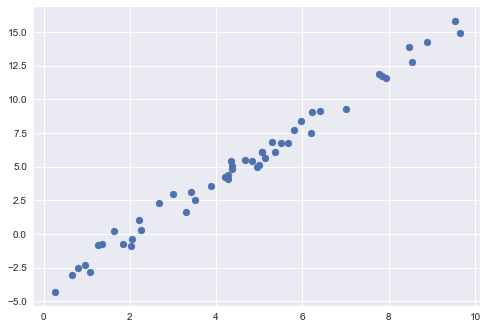

In [18]:
plt.scatter( x, y )

##### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

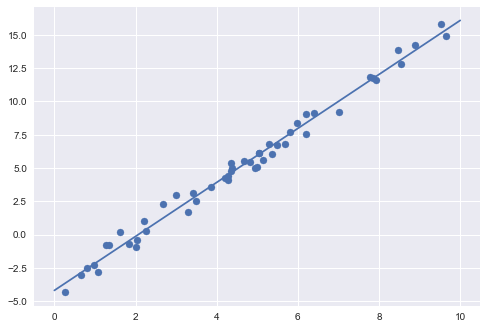

In [22]:
model = LinearRegression( fit_intercept = True )
model.fit( x[:, np.newaxis] , y )

xfit = np.linspace( 0, 10, 1000 )
yfit = model.predict( xfit[:, np.newaxis] )

plt.scatter( x, y )
plt.plot( xfit, yfit)

In [23]:
print( "Model slope:", model.coef_[0] )
print( "Model intercept:", model.intercept_ )

Model slope: 2.02796367517
Model intercept: -4.19336876963


### Linear regression with polynomial basis functions

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

The cleanest way to fit linear model (with polynomial features transformations) is to build a pipeline

In [26]:
poly_model = make_pipeline( PolynomialFeatures(7), 
                            LinearRegression() )

Fit complicated functions

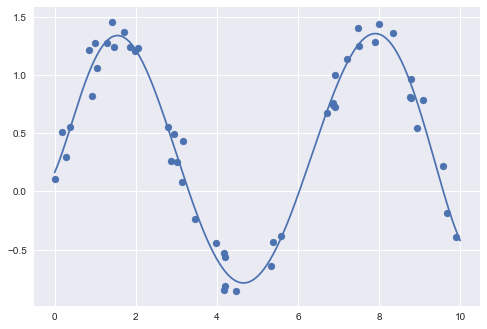

In [31]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.5 * rng.rand(50)

poly_model.fit( x[:, np.newaxis], y )

xfit = np.linspace( 0, 10, 1000 )
yfit = poly_model.predict( xfit[:, np.newaxis] )

plt.scatter( x, y )
plt.plot( xfit, yfit )

Note that we fit a linear model! 

### Add a new basis familiy: Gaussians

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

In [44]:
class GaussianFeatures( BaseEstimator, TransformerMixin ):
    
    """ Uniformly spaced Gaussian features for one-dimensional input """
    
    def __init__( self, N, width_factor = 2.0 ):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis( x, y, width, axis = None ):
        arg = ( x - y ) / width
        return np.exp( -0.5 * np.sum( arg ** 2, axis) )
    
    def fit( self, X , y=None ):
        # create N centers spread along the data range
        self.centers_ = np.linspace( X.min(), X.max() , self.N )
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0] )
        return self
    
    def transform( self, X ):
        return self._gauss_basis( X[:,:,np.newaxis], self.centers_, self.width_, axis = 1 )

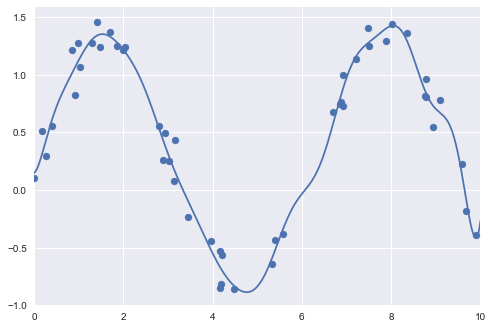

In [46]:
gauss_model = make_pipeline( GaussianFeatures(20), LinearRegression() )
gauss_model.fit( x[:, np.newaxis], y )
yfit = gauss_model.predict( xfit[:, np.newaxis] )

plt.scatter( x, y )
plt.plot(xfit, yfit)
plt.xlim(0,10);

If we use too many Gaussians:

In [48]:
def basis_plot( model, title = None ):
    fig, ax = plt.subplots( 2, sharex = True )
    model.fit( x[:, np.newaxis], y )
    ax[0].scatter( x, y )
    ax[0].plot( xfit, model.predict(xfit[:,np.newaxis] ) )
    ax[0].set( xlabel = 'x', ylabel = 'y', ylim = (-1.5, 1.5) )
    
    if title:
        ax[0].set_title( title )
    
    ax[1].plot( model.steps[0][1].centers_, 
                model.steps[1][1].coef_ )
    ax[1].set( xlabel = 'basis location', ylabel = 'coefficient', xlim =(0,10))

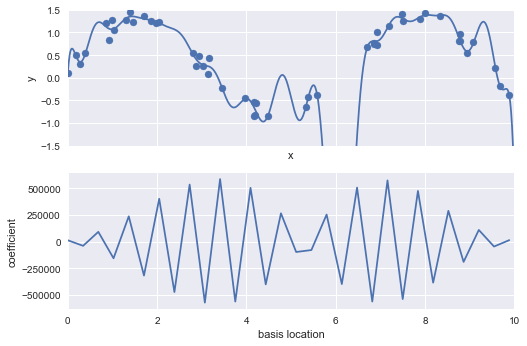

In [49]:
model = make_pipeline( GaussianFeatures(30), LinearRegression() )
basis_plot(model)

Note that coeficients blow up, and that they try to cancel each other

### Regularization

In [47]:
from sklearn.linear_model import Ridge

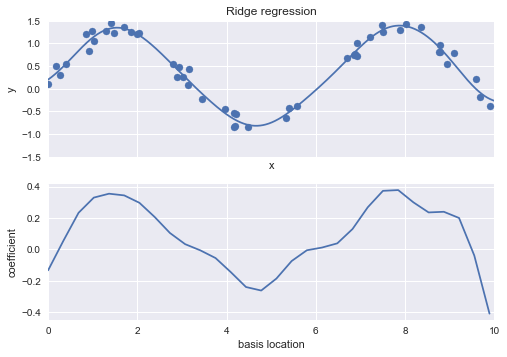

In [50]:
model = make_pipeline( GaussianFeatures(30), Ridge( alpha =0.1) )
basis_plot( model, title = 'Ridge regression' )

Regularization penalizes large coeficients giving a much smoothter fit

## Predicting Bicycle traffic

Downloading the data set

In [51]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1104k    0 1104k    0     0   460k      0 --:--:--  0:00:02 --:--:--  491k


In [59]:
# !curl -o datasets/BicycleWeather.csv https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  229k  100  229k    0     0   712k      0 --:--:-- --:--:-- --:--:--  791k


Importing

In [60]:
import pandas as pd

In [61]:
counts = pd.read_csv('datasets/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('datasets/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [62]:
counts.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [67]:
weather.head(3)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [71]:
daily = counts.resample( 'd' ).sum()
daily['Total'] = daily.sum( axis =1 )
daily.head(2)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total
Date,,,
2012-10-03,1760.0,1761.0,3521.0
2012-10-04,1708.0,1767.0,3475.0


Add a binary column to monitor the date. Reanme colums.

In [72]:
daily.rename(columns={'Fremont Bridge West Sidewalk': 'West', 'Fremont Bridge East Sidewalk': 'East'}, inplace=True)

In [76]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    daily[ day ] = (daily.index.dayofweek == i ).astype(float)

In [77]:
daily.head(2)

,West,East,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,,,
2012-10-03,1760.0,1761.0,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,1708.0,1767.0,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Accounting for holidays

In [78]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [79]:
cal = USFederalHolidayCalendar()

In [83]:
holydays = cal.holidays( start = '2012', end = '2016' )

In [86]:
daily = daily.join( pd.Series(1, index= holydays, name = 'holiday') ).fillna(0)

Accounting for daylight hours, with astronomical calculations

In [87]:
def hours_of_daylight( date, axis = 23.44, latitude = 47.61 ):
    
    """ Compute the hours of daylight for the given date """
    
    days = (date - pd.datetime(2000, 12, 21) ).days
    
    m = (1. - np.tan( np.radians(latitude) )  * 
        np.tan( np.radians(axis) * np.cos(days * 2 * np.pi /365.25) ))
    
    return 24. * np.degrees( np.arccos( 1 - np.clip(m,0,2) ))/180.

In [91]:
daily['daylight_hrs'] = list( map( hours_of_daylight , daily.index ) )

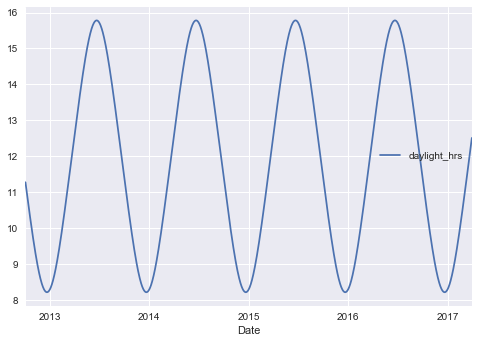

In [92]:
daily[['daylight_hrs']].plot()

Visualization of hours of daylight in Seattle

Add weather features, average temperature, if it was a rainy day and in that case how much it rained

In [95]:
# temperatures are in 0.1 degree --> convert to degree
weather[ 'TMIN' ] /= 10 
weather[ 'TMAX' ] /= 10 
weather[ 'Temp(C)'] = 0.5 * (weather[ 'TMIN' ] + weather[ 'TMAX' ] )

In [96]:
# convert precipitation to inches
weather[ 'PRCP' ] /= 254
weather[ 'dry_day' ] = (weather[ 'PRCP' ] == 0).astype( int )

In [98]:
daily = daily.join( weather[['PRCP', 'Temp(C)', 'dry_day']] )

Monitor how day passes to see how the cycling tendency change

In [99]:
daily[ 'annual' ] = (daily.index - daily.index[0] ).days / 365.

In [100]:
daily.head()

,West,East,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp(C),dry_day,annual
Date,,,,,,,,,,,,,,,,
2012-10-03,1760.0,1761.0,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,0.1335,1.0,0.000000
2012-10-04,1708.0,1767.0,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,0.1360,1.0,0.002740
2012-10-05,1558.0,1590.0,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,0.1530,1.0,0.005479
2012-10-06,1080.0,926.0,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,0.1585,1.0,0.008219
2012-10-07,1191.0,951.0,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,0.1585,1.0,0.010959


We have now the data set to build a linear regression model

In [104]:
colum_names = daily.columns[3:]

In [111]:
daily.dropna( axis = 0 , inplace = True ) # The bicycle is updated (2017) but not the weather
X = daily[ colum_names ]
Y = daily[ 'Total' ]

We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts

In [112]:
model = LinearRegression( fit_intercept= False )
model.fit( X , Y )
daily[ 'Predicted' ] = model.predict( X )

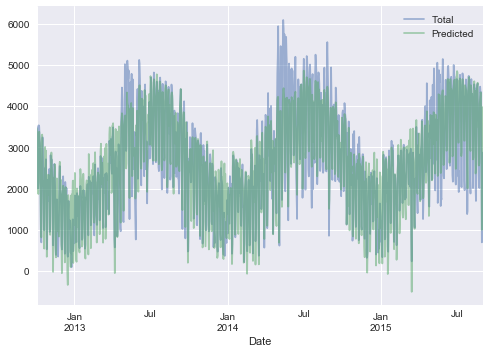

In [113]:
daily[ [ 'Total', 'Predicted' ] ].plot( alpha = 0.5 )

We screwed up in the summer.
The linear model as it stands do not take into account that people ride less at very high or very low temperatures

#### Coeficients of the model

In [114]:
params = pd.Series( model.coef_, index = X.columns )

In [115]:
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
Temp(C)         6516.279111
dry_day          547.698592
annual            26.942713
dtype: float64

Lets compute the uncertainty on the coefficients using bootstrap resampling.

In [116]:
from sklearn.utils import resample

In [125]:
np.random.seed(1)
err = np.std( [ model.fit( *resample(X,Y) ).coef_  for i in range(1000) ] 
             , axis = 0 )

In [129]:
print( pd.DataFrame( {
            'effect' : params.round(),
            'error'  : err.round()
        }) )

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
Temp(C)       6516.0  360.0
dry_day        548.0   33.0
annual          27.0   18.0


Interpretation:

- There are many more riders on the weekdays compared to weekend or holidays

- Per each hour of dayligth 129 +- more people ride

- A dry day encourages 548 +- 33 more riders

- ...